In [149]:
# 由于要实现的模型涉及到比较复杂的数据处理和分析，我们将从简单的数据探索开始，
# 然后尝试定义并计算动量指标，最后进行简单的可视化展示。
# 本例将重点放在如何根据比赛分数计算动量，并不会构建一个完整的状态空间模型。

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
# 读取数据
df = pd.read_csv('Wimbledon_featured_matches.csv')

# 选择一场特定的比赛进行分析，根据题目描述选择2023年温布尔登决赛
# 假设决赛的match_id为"2023-wimbledon-1701"
match_id = "2023-wimbledon-1701"
match_data = df[df['match_id'] == match_id].copy()
match_data.reset_index(inplace=True,drop=True)

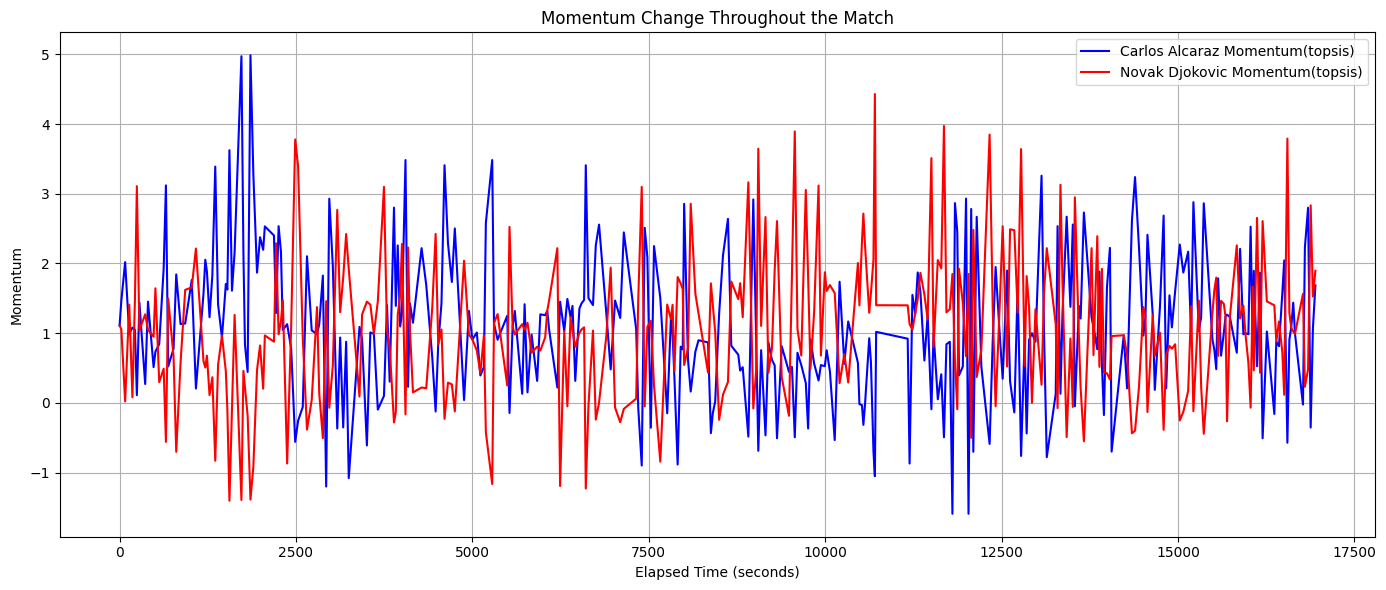

In [150]:
from sklearn.preprocessing import MinMaxScaler

# 创建新的列 score_difference
def map_score_to_number(score):
    score_mapping = {'0': 0, '15': 1, '30': 2, '40': 3, 'AD': 4}
    return score_mapping.get(score, 0)

# 应用映射函数到 p1_score 和 p2_score 列
match_data['p1_score_number'] = match_data['p1_score'].apply(map_score_to_number)
match_data['p2_score_number'] = match_data['p2_score'].apply(map_score_to_number)

# 计算得分差
match_data['score_difference'] = match_data['p1_score_number'] - match_data['p2_score_number']
match_data['game_difference'] = match_data['p1_games'] - match_data['p2_games']
match_data['set_difference'] = match_data['p1_sets'] - match_data['p2_sets']

# 选择进行Topsis分析的特征列
selected_features = ['p1_net_pt_won', 'p1_ace', 'score_difference', 'game_difference', 'set_difference', 'p1_winner', 'p1_double_fault', 'p1_unf_err', 'p1_break_pt_won', 'speed_mph']
selected_features += ['p2_net_pt_won','p2_ace', 'p2_winner', 'p2_double_fault', 'p2_unf_err', 'p2_break_pt_won']

# 使用均值填充speed
mean_speed = match_data['speed_mph'].mean()
match_data['speed_mph'].fillna(mean_speed, inplace=True)

# 提取这些特征列的数据
features_data = match_data[selected_features]

# 步骤1：数据标准化（使用 Min-Max 标准化）
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(features_data)

# 步骤2：计算每个指标的信息熵
entropy_values = -normalized_data * np.log2(normalized_data)
entropy_values[np.isnan(entropy_values)] = 0  # 处理NaN值
entropy_per_indicator = np.sum(entropy_values, axis=0)

# 步骤3：计算每个指标的权重
weights = 1 - (entropy_per_indicator / np.sum(entropy_per_indicator))

# 步骤4：计算加权标准化值
weighted_normalized_data = normalized_data * weights

# 步骤5：正向化负向指标
# 假设所有指标都是越大越好，后续再处理正负号

# 步骤6：计算正负理想解
positive_ideal_solution = weighted_normalized_data.max(axis=0)
negative_ideal_solution = weighted_normalized_data.min(axis=0)

# 步骤7：计算距离
distance_to_positive_ideal = np.linalg.norm(weighted_normalized_data - positive_ideal_solution, axis=1)
distance_to_negative_ideal = np.linalg.norm(weighted_normalized_data - negative_ideal_solution, axis=1)

# 步骤8：计算综合得分
composite_score = distance_to_negative_ideal / (distance_to_positive_ideal + distance_to_negative_ideal)

# 步骤2：使用比分差距进行势头计算
match_data['score_momentum'] = match_data['score_difference'] * composite_score

# 步骤3：将各项比分差异乘以 composite_score
match_data['game_momentum'] = match_data['game_difference'] * composite_score
match_data['set_momentum'] = match_data['set_difference'] * composite_score

# 步骤4：将所有势头指标结合计算动量
match_data['p1_momentum_topsis'] = -match_data['score_momentum'] + match_data['p1_net_pt_won'] + match_data['p1_ace'] - match_data['game_momentum'] - match_data['set_momentum']
match_data['p1_momentum_topsis'] += match_data['p1_winner'] - match_data['p1_double_fault'] - match_data['p1_unf_err'] + match_data['p1_break_pt_won'] +0.01*match_data['speed_mph']
match_data['p1_momentum_topsis'] += -match_data['p2_winner'] - match_data['p2_ace'] - match_data['p2_break_pt_won']
match_data['p2_momentum_topsis'] = match_data['score_momentum'] + match_data['p2_net_pt_won'] + match_data['p2_ace'] + match_data['game_momentum'] + match_data['set_momentum']
match_data['p2_momentum_topsis'] += match_data['p2_winner'] - match_data['p2_double_fault'] - match_data['p2_unf_err'] + match_data['p2_break_pt_won'] +0.01*match_data['speed_mph']
match_data['p2_momentum_topsis'] += -match_data['p1_winner'] - match_data['p1_ace'] - match_data['p1_break_pt_won']

import matplotlib.pyplot as plt
import numpy as np

# 将 elapsed_time 转换为可比较的数值（秒）
elapsed_seconds = match_data['elapsed_time'].apply(lambda x: sum(int(a) * 60**index for index, a in enumerate(reversed(x.split(":")))))

# 绘制势头变化图
plt.figure(figsize=(14, 6))

# 绘制球员1的势头变化
plt.plot(elapsed_seconds, match_data['p1_momentum_topsis'], label=match_data['player1'].iloc[0] + " Momentum(topsis)", color='blue')
# 绘制球员2的势头变化
plt.plot(elapsed_seconds, match_data['p2_momentum_topsis'], label=match_data['player2'].iloc[0] + " Momentum(topsis)", color='red')

# 添加图例
plt.legend()

# 设置标题和坐标轴标签
plt.title('Momentum Change Throughout the Match')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Momentum')

# 改善图表的可读性
plt.grid(True)
plt.tight_layout()

# 显示图表
plt.show()

In [151]:
# 改进势头计算函数以包括赢得的局数和盘数，以及更精确的发球优势计算
def calculate_momentum_improved(df, index, window_size=6):
    start_index = max(index - window_size, 0)
    end_index = min(index + window_size + 1, len(df))
    time_window_df = df.iloc[start_index:end_index]

    # 初始化势头值
    p1_momentum = 0
    p2_momentum = 0

    # 赢得的局数和盘数
    p1_sets_won = time_window_df['p1_sets'].iloc[-1] - time_window_df['p1_sets'].iloc[0]
    p2_sets_won = time_window_df['p2_sets'].iloc[-1] - time_window_df['p2_sets'].iloc[0]
    p1_games_won = time_window_df['p1_games'].iloc[-1] - time_window_df['p1_games'].iloc[0]
    p2_games_won = time_window_df['p2_games'].iloc[-1] - time_window_df['p2_games'].iloc[0]

    # 发球优势
    # 假设发球方在每个得分上的额外权重为0.1
    serve_advantage_weight = 1/5
    p1_serve_advantage = (time_window_df[time_window_df['server'] == 1]['point_victor'] == 1).sum() * serve_advantage_weight
    p2_serve_advantage = (time_window_df[time_window_df['server'] == 2]['point_victor'] == 2).sum() * serve_advantage_weight

    # 其他因素（得分优势、破发点、非受迫性失误、制胜分）
    p1_points_advantage = time_window_df['point_victor'].apply(lambda x: x == 1).sum() - time_window_df['point_victor'].apply(lambda x: x == 2).sum()
    p2_points_advantage = -p1_points_advantage
    p1_break_points_won = time_window_df['p1_break_pt_won'].sum()
    p2_break_points_won = time_window_df['p2_break_pt_won'].sum()
    p1_unforced_errors = -time_window_df['p1_unf_err'].sum()
    p2_unforced_errors = -time_window_df['p2_unf_err'].sum()
    p1_winners = time_window_df['p1_winner'].sum()
    p2_winners = time_window_df['p2_winner'].sum()

    

    # 合并计算势头
    p1_momentum = p1_points_advantage + p1_serve_advantage + p1_break_points_won + p1_unforced_errors + p1_winners + p1_sets_won + p1_games_won
    p2_momentum = p2_points_advantage + p2_serve_advantage + p2_break_points_won + p2_unforced_errors + p2_winners + p2_sets_won + p2_games_won

    return p1_momentum, p2_momentum




# 对数据集中的每一行应用计算势头的函数
momentum_values = [calculate_momentum_improved(match_data, index) for index in range(len(match_data))]

momentum_values
# len(momentum_values)

[(0.0, 1.8),
 (1.0, 0.8),
 (-1.0, 2.0),
 (-2.0, 3.2),
 (-4.0, 5.2),
 (-5.0, 7.2),
 (-7.0, 8.2),
 (-4.8, 6.0),
 (-3.5999999999999996, 6.0),
 (-6.6, 9.0),
 (-7.6, 10.0),
 (-7.6, 10.0),
 (-5.6, 7.8),
 (-5.6, 6.8),
 (-7.6, 9.0),
 (-6.6, 10.0),
 (-6.6, 9.8),
 (-3.4000000000000004, 7.8),
 (-3.4000000000000004, 6.8),
 (-3.4000000000000004, 6.8),
 (-3.4000000000000004, 6.8),
 (-3.4000000000000004, 6.8),
 (-3.4000000000000004, 4.8),
 (-2.4, 5.6),
 (-4.4, 9.8),
 (-7.4, 12.0),
 (-4.4, 9.8),
 (-5.4, 9.8),
 (-5.4, 8.8),
 (-2.2, 7.8),
 (-2.2, 7.8),
 (-3.2, 7.8),
 (-3.2, 7.8),
 (-2.2, 7.8),
 (-2.2, 7.8),
 (-1.2000000000000002, 8.0),
 (-1.2000000000000002, 6.2),
 (-1.2000000000000002, 6.2),
 (-0.20000000000000018, 7.2),
 (-2.0, 3.2),
 (-1.0, 3.0),
 (1.2000000000000002, -1.2000000000000002),
 (0.20000000000000018, -1.2000000000000002),
 (0.20000000000000018, -1.2000000000000002),
 (4.2, -4.2),
 (7.2, -6.2),
 (4.0, -3.0),
 (-0.19999999999999996, 0.20000000000000018),
 (-1.2, 0.20000000000000018),
 (1.8,

In [152]:
p1_momentum=[]
p2_momentum=[]
for i in momentum_values:
    p1_momentum.append(i[0])
    p2_momentum.append(i[1])

In [153]:
# 将计算得到的势头值分配回原始数据集
match_data['p1_momentum']=pd.DataFrame(p1_momentum)
match_data['p2_momentum']=pd.DataFrame(p2_momentum)

In [154]:
# 设置 Topsis 方法的权重
topsis_weight = 0.8

# 将 Topsis 方法的结果加权合并到总势头中
match_data['p1_momentum_combined'] = (1 - topsis_weight) * match_data['p1_momentum'] + topsis_weight * match_data['p1_momentum_topsis']
match_data['p2_momentum_combined'] = (1 - topsis_weight) * match_data['p2_momentum'] + topsis_weight * match_data['p2_momentum_topsis']


In [155]:
# 显示更新后的数据集的前几行，包括势头值
match_data[['match_id', 'player1', 'player2', 'elapsed_time', 'p1_momentum', 'p2_momentum']].head()

,match_id,player1,player2,elapsed_time,p1_momentum,p2_momentum
0,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,00:00:00,0.0,1.8
1,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,00:00:25,1.0,0.8
2,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,00:01:19,-1.0,2.0
3,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,00:02:17,-2.0,3.2
4,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,00:03:02,-4.0,5.2


In [163]:
# 保存数据
match_data['momentum_difference'] = match_data['p1_momentum_combined'] - match_data['p2_momentum_combined']
match_data['actual_score_diff'] = match_data['p1_points_won'] - match_data['p2_points_won']


# Now, we'll save this subset to a new CSV file
match_data.to_csv(f'yang_{match_id}_try.csv', index=False)

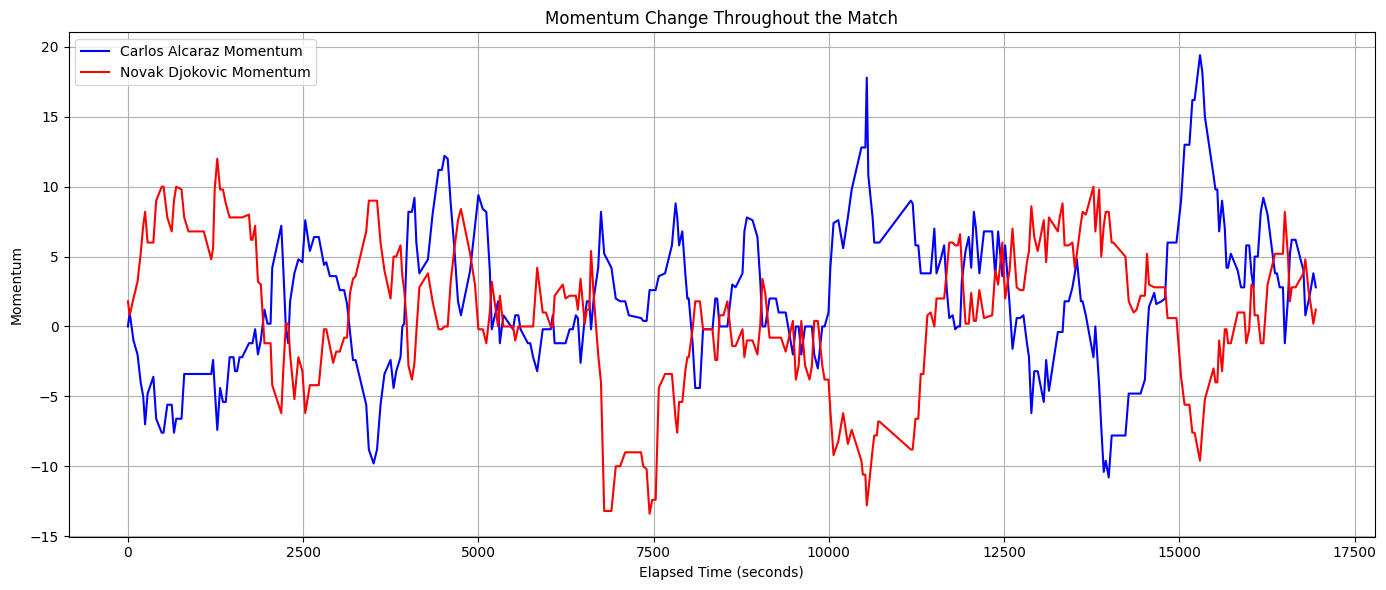

In [157]:
import matplotlib.pyplot as plt
import numpy as np

# 将 elapsed_time 转换为可比较的数值（秒）
elapsed_seconds = match_data['elapsed_time'].apply(lambda x: sum(int(a) * 60**index for index, a in enumerate(reversed(x.split(":")))))

# 绘制势头变化图
plt.figure(figsize=(14, 6))

# 绘制球员1的势头变化
plt.plot(elapsed_seconds, match_data['p1_momentum'], label=match_data['player1'].iloc[0] + " Momentum", color='blue')
# 绘制球员2的势头变化
plt.plot(elapsed_seconds, match_data['p2_momentum'], label=match_data['player2'].iloc[0] + " Momentum", color='red')

# 添加图例
plt.legend()

# 设置标题和坐标轴标签
plt.title('Momentum Change Throughout the Match')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Momentum')

# 改善图表的可读性
plt.grid(True)
plt.tight_layout()

# 显示图表
plt.show()


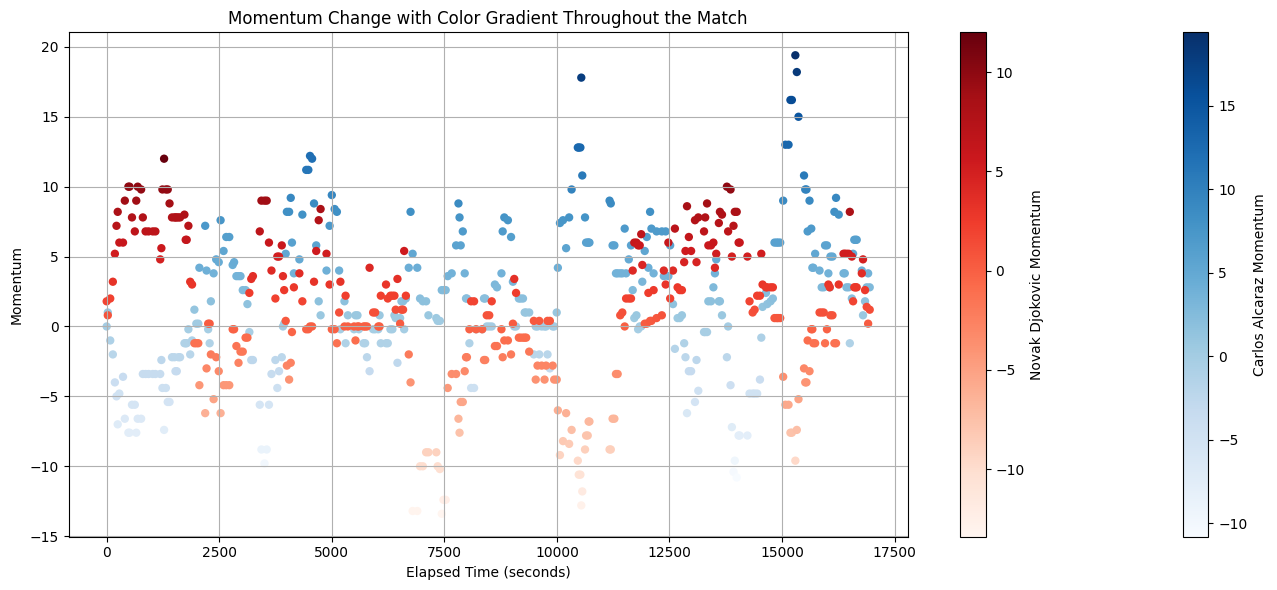

In [158]:
# 为了使用渐变色表示球员在特定时刻的优势程度，我们将使用散点图，其中点的颜色深浅表示势头的大小。

# 创建颜色映射
# 势头值范围
momentum_range = np.linspace(min(min(match_data['p1_momentum']), min(match_data['p2_momentum'])),
                             max(max(match_data['p1_momentum']), max(match_data['p2_momentum'])), num=100)
# 创建一个颜色映射对象
cmap = plt.get_cmap('coolwarm')

# 绘制势头变化图
plt.figure(figsize=(14, 6))

# 绘制球员1的势头变化
sc1 = plt.scatter(elapsed_seconds, match_data['p1_momentum'], c=match_data['p1_momentum'], cmap='Blues', label=match_data['player1'].iloc[0] + " Momentum", edgecolor='none')
# 绘制球员2的势头变化
sc2 = plt.scatter(elapsed_seconds, match_data['p2_momentum'], c=match_data['p2_momentum'], cmap='Reds', label=match_data['player2'].iloc[0] + " Momentum", edgecolor='none')

# 添加颜色条
cbar1 = plt.colorbar(sc1, orientation='vertical')
cbar2 = plt.colorbar(sc2, orientation='vertical')
cbar1.set_label(match_data['player1'].iloc[0] + ' Momentum')
cbar2.set_label(match_data['player2'].iloc[0] + ' Momentum')

# 设置标题和坐标轴标签
plt.title('Momentum Change with Color Gradient Throughout the Match')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Momentum')

# 显示图表
plt.grid(True)
plt.tight_layout()
plt.show()


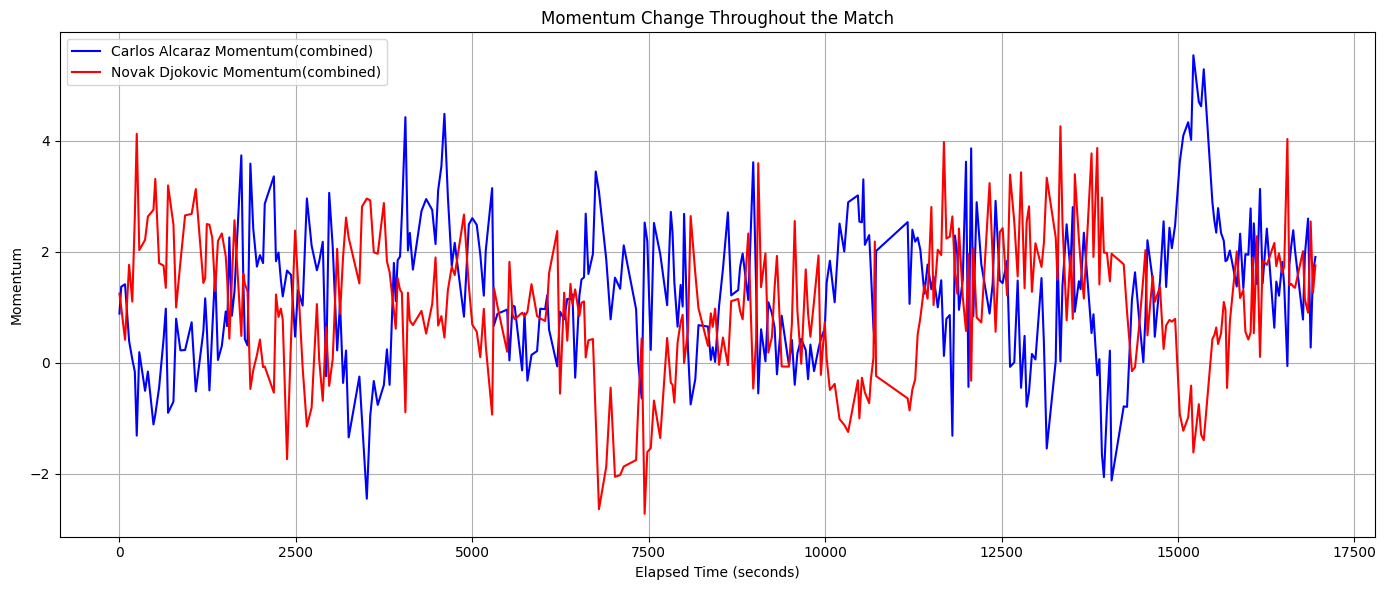

In [159]:
import matplotlib.pyplot as plt
import numpy as np

# 将 elapsed_time 转换为可比较的数值（秒）
elapsed_seconds = match_data['elapsed_time'].apply(lambda x: sum(int(a) * 60**index for index, a in enumerate(reversed(x.split(":")))))

# 绘制势头变化图
plt.figure(figsize=(14, 6))

# 绘制球员1的势头变化
plt.plot(elapsed_seconds, match_data['p1_momentum_combined'], label=match_data['player1'].iloc[0] + " Momentum(combined)", color='blue')
# 绘制球员2的势头变化
plt.plot(elapsed_seconds, match_data['p2_momentum_combined'], label=match_data['player2'].iloc[0] + " Momentum(combined)", color='red')

# 添加图例
plt.legend()

# 设置标题和坐标轴标签
plt.title('Momentum Change Throughout the Match')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Momentum')

# 改善图表的可读性
plt.grid(True)
plt.tight_layout()

# 显示图表
plt.show()

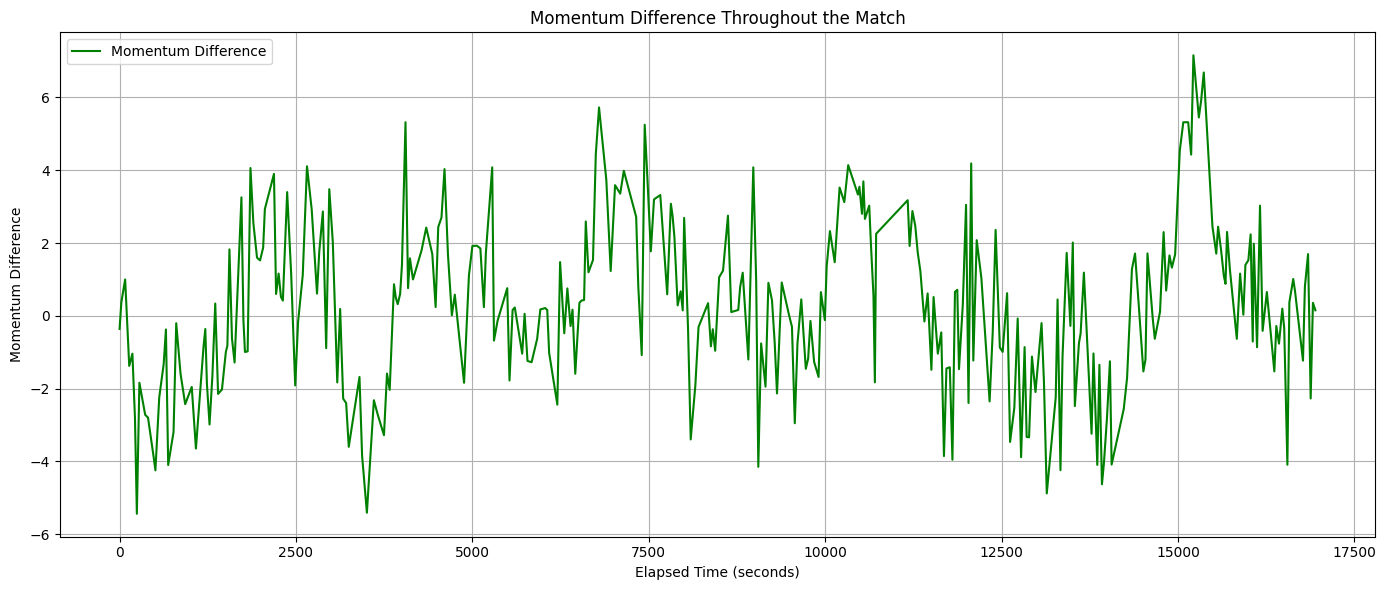

In [160]:
# 计算势头差值
match_data['momentum_difference'] = match_data['p1_momentum_combined'] - match_data['p2_momentum_combined']

# 绘制势头差值图
plt.figure(figsize=(14, 6))

# 绘制势头差值变化
plt.plot(elapsed_seconds, match_data['momentum_difference'], label="Momentum Difference", color='green')

# 添加图例
plt.legend()

# 设置标题和坐标轴标签
plt.title('Momentum Difference Throughout the Match')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Momentum Difference')

# 改善图表的可读性
plt.grid(True)
plt.tight_layout()

# 显示图表
plt.show()


In [161]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# # # 加载数据
# # df = pd.read_csv("C:\\Users\\a\\Desktop\\Wimbledon_featured_matches.csv")
# 
# # 选择一个示例比赛进行分析
# match_id = df['match_id'].unique()[0]
# match_data = df[df['match_id'] == match_id]

# 计算得分差
match_data['actual_score_diff'] = match_data['p1_points_won'] - match_data['p2_points_won']

match_data['elapsed_seconds'] = pd.to_timedelta(match_data['elapsed_time']).dt.total_seconds()

match_data['momentum_difference'] = match_data['p1_momentum_combined'] - match_data['p2_momentum_combined']
# 确保数据是按时间排序的
match_data.sort_values('elapsed_seconds', inplace=True)

# 准备Granger因果检验的数据：这里我们取势头差和得分差
# gc_data = match_data[['momentum_difference', 'actual_score_diff']]

from statsmodels.tsa.stattools import adfuller

# 以势头差序列为例进行ADF单位根检验
momentum_adf_result = adfuller(match_data['momentum_difference'])
print('Momentum Difference ADF Statistic: %f' % momentum_adf_result[0])
print('Momentum Difference p-value: %f' % momentum_adf_result[1])

# 以得分差序列为例进行ADF单位根检验
score_adf_result = adfuller(match_data['actual_score_diff'])
print('Actual Score Difference ADF Statistic: %f' % score_adf_result[0])
print('Actual Score Difference p-value: %f' % score_adf_result[1])

# 对得分差进行一阶差分
match_data['actual_score_diff_diffed'] = match_data['actual_score_diff'].diff().dropna()

# 再次进行ADF检验
diffed_score_adf_result = adfuller(match_data['actual_score_diff_diffed'].dropna())
print('Differenced Actual Score Difference ADF Statistic: %f' % diffed_score_adf_result[0])
print('Differenced Actual Score Difference p-value: %f' % diffed_score_adf_result[1])

gc_data = pd.DataFrame({
    'momentum_difference': match_data['momentum_difference'].iloc[1:],  # 由于差分，第一个值是NaN
    'actual_score_diff_diffed': match_data['actual_score_diff_diffed'].dropna()
})

# 对数据进行Granger因果检验
# maxlag参数是最大滞后数，这需要根据数据的具体情况来确定
# 这里假设检验最大滞后为4
gc_test_results = grangercausalitytests(gc_data, maxlag=4, verbose=True)
print(gc_test_results)

# 注意：gc_data中的第一列被检验是否是第二列的Granger原因


Momentum Difference ADF Statistic: -4.652794
Momentum Difference p-value: 0.000103
Actual Score Difference ADF Statistic: -1.531502
Actual Score Difference p-value: 0.517874
Differenced Actual Score Difference ADF Statistic: -18.166561
Differenced Actual Score Difference p-value: 0.000000

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=61.6887 , p=0.0000  , df_denom=329, df_num=1
ssr based chi2 test:   chi2=62.2513 , p=0.0000  , df=1
likelihood ratio test: chi2=57.0553 , p=0.0000  , df=1
parameter F test:         F=61.6887 , p=0.0000  , df_denom=329, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=31.2374 , p=0.0000  , df_denom=326, df_num=2
ssr based chi2 test:   chi2=63.4330 , p=0.0000  , df=2
likelihood ratio test: chi2=58.0345 , p=0.0000  , df=2
parameter F test:         F=31.2374 , p=0.0000  , df_denom=326, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=17.2761 , p=0.0000  , df_denom=3

In [162]:
match_data['actual_score_diff'] = match_data['p1_points_won'] - match_data['p2_points_won']